<a href="https://colab.research.google.com/github/edsonportosilva/OptiCommPy/blob/main/examples/test_carrierPhaseRecovery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test carrier phase recovery algorithms for coherent receivers

This notebook contains test cases for evaluating the performance of different carrier frequency and phase recovery algorithms in coherent optical communication systems. In the simulations, signals are generated and impaired with phase noise and frequency offset. Next, different algorithms available in OptiCommPy are applied to compensate for carrier frequency offset and phase noise. To verify that each algorithm is working properly, each test case should output clear QAM constellations, without frequency offset, phase rotation, and possible exhibiting some residual phase noise.

In [1]:
if 'google.colab' in str(get_ipython()):    
    ! git clone -b main https://github.com/edsonportosilva/OptiCommPy
    from os import chdir as cd
    cd('/content/OptiCommPy/')
    ! pip install . 

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from optic.dsp.core import pulseShape, firFilter, decimate, symbolSync, pnorm, signal_power
from optic.models.devices import pdmCoherentReceiver, basicLaserModel
from optic.models.channels import awgn
from optic.models.tx import simpleWDMTx
from optic.dsp.carrierRecovery import cpr
from optic.utils import parameters, dBm2W
from optic.comm.metrics import fastBERcalc, monteCarloGMI, monteCarloMI, calcEVM
from optic.comm.modulation import grayMapping
from optic.plot import pconst

import scipy.constants as const
from numba import njit

In [3]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [4]:
figsize(10, 3)

In [5]:
%load_ext autoreload
%autoreload 2
#%load_ext line_profiler

In [6]:
constCMAP = 'turbo' # configure colormap for constellation plots


## Transmitter

**Polarization multiplexed signal generation**

In [7]:
# Transmitter parameters:
paramTx = parameters()
paramTx.M   = 64  # order of the modulation format
paramTx.constType = 'qam'  # constellation type
paramTx.Rs  = 32e9 # symbol rate [baud]
paramTx.SpS = 8  # samples per symbol
paramTx.nBits = int(np.log2(paramTx.M)*1e5) # total number of bits per polarization
paramTx.seed = 123   # seed for generation of the pseudo-random symbol sequence
paramTx.pulse = 'rrc' # pulse shaping filter
paramTx.nPulseTaps = 1024 # number of pulse shaping filter coefficients
paramTx.pulseRollOff = 0.01 # RRC rolloff
paramTx.powerPerChannel = 1 # power per WDM channel [dBm]
paramTx.nChannels = 1 # number of WDM channels
paramTx.Fc = 193.1e12 # central optical frequency of the WDM spectrum
paramTx.laserLinewidth = 100e3 # laser linewidth in Hz
paramTx.nPolModes = 2  # number of signal modes [2 for polarization multiplexed signals]


# generate WDM signal
sigTx, symbTx_, paramTx = simpleWDMTx(paramTx)

Fs = paramTx.Rs*paramTx.SpS # sampling frequency

  0%|          | 0/1 [00:00<?, ?it/s]

### Add noise to fix the SNR

In [8]:
SNR = 30
sigCh = awgn(sigTx, SNR, Fs, paramTx.Rs)

###  Simulate a coherent receiver frontend subject to laser phase noise and frequency offset

Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 10.00 dBm, lw: 100.00 kHz, FO: 150.00 MHz



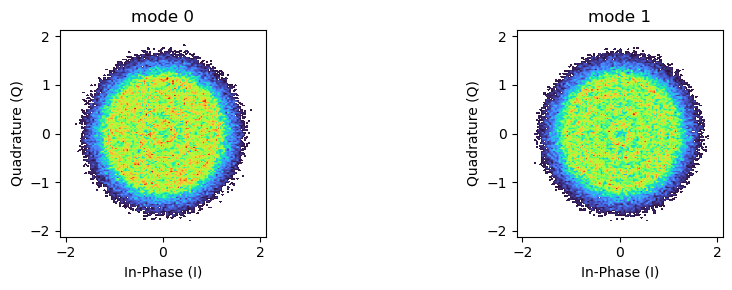

In [10]:
# Receiver

# parameters
chIndex  = 0    # index of the channel to be demodulated

freqGrid = paramTx.wdmFreqGrid
π  = np.pi
t  = np.arange(0, len(sigCh))*1/Fs 

print('Demodulating channel #%d , fc: %.4f THz, λ: %.4f nm\n'\
      %(chIndex, (paramTx.Fc + freqGrid[chIndex])/1e12, const.c/(paramTx.Fc + freqGrid[chIndex])/1e-9))

symbTx = symbTx_[:,:,chIndex]

# local oscillator (LO) parameters:
FO      = 150e6                 # frequency offset
Δf_lo   = freqGrid[chIndex]+FO  # downshift of the channel to be demodulated

# generate CW laser LO field
paramLO = parameters()
paramLO.P = 10              # power in dBm
paramLO.lw = 100e3          # laser linewidth
paramLO.RIN_var = 0
paramLO.Ns = len(sigCh)
paramLO.Fs = Fs

sigLO = basicLaserModel(paramLO)
sigLO = sigLO*np.exp(1j*2*π*Δf_lo*t) # add frequency offset

print('Local oscillator P: %.2f dBm, lw: %.2f kHz, FO: %.2f MHz\n'\
      %(paramLO.P, paramLO.lw/1e3, FO/1e6))

# polarization multiplexed coherent optical receiver
sigRx = pdmCoherentReceiver(sigCh, sigLO, θsig = 0)

# plot constellation
pconst(sigRx[0::paramTx.SpS,:],R =1.5, cmap=constCMAP);

### Matched filtering

In [11]:
# Rx filtering

# Matched filtering
if paramTx.pulse == 'nrz':
    pulse = pulseShape('nrz', paramTx.SpS)
elif paramTx.pulse == 'rrc':
    pulse = pulseShape('rrc', paramTx.SpS, N=paramTx.nPulseTaps, alpha=paramTx.pulseRollOff, Ts=1/paramTx.Rs)
    
pulse = pulse/np.max(np.abs(pulse))            
sigRx = firFilter(pulse, sigRx)

### Downsample to 1 sample/symbol and power normalization

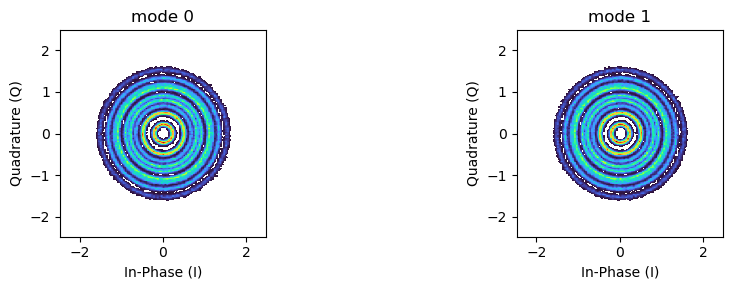

In [12]:
# decimation
paramDec = parameters()
paramDec.SpS_in  = paramTx.SpS
paramDec.SpS_out = 1
sigRx = decimate(sigRx, paramDec)

# power normalization
sigRx = pnorm(sigRx) 
d = pnorm(symbTx)

pconst(sigRx, R=1.75, cmap=constCMAP);

### Carrier phase recovery with blind phase search (BPS)

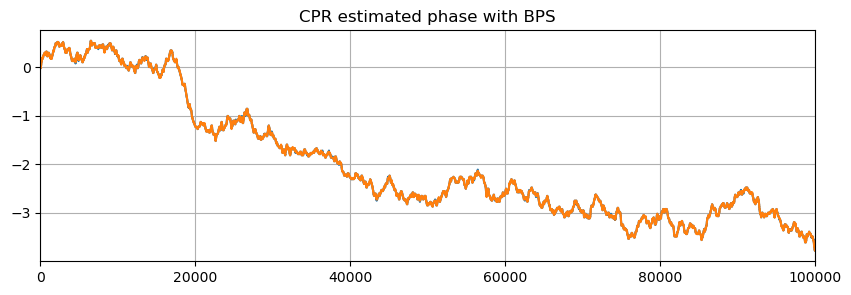

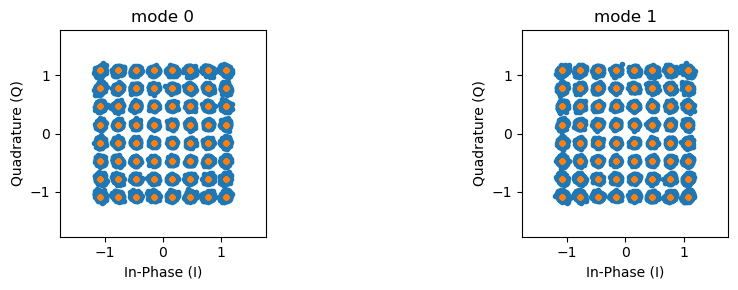

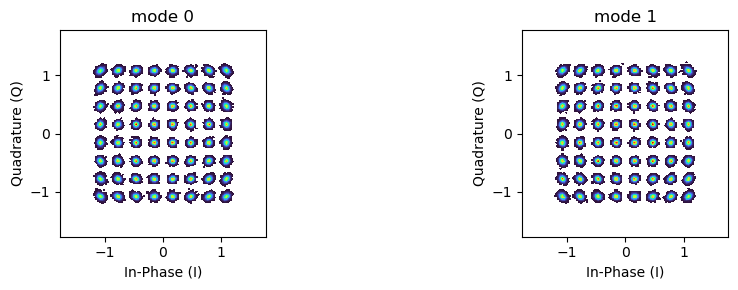

      pol.X      pol.Y      
 SER: 0.00e+00,  1.02e-05
 BER: 0.00e+00,  1.70e-06
 SNR: 27.79 dB,  27.77 dB
 EVM: 0.17 %,    0.17 %
  MI: 6.00 bits, 6.00 bits
 GMI: 6.00 bits, 6.00 bits
NGMI: 1.00,      1.00


In [13]:
paramCPR = parameters()
paramCPR.alg = 'bps'
paramCPR.M   = paramTx.M
paramCPR.constType = paramTx.constType
paramCPR.shapingFactor = paramTx.shapingFactor
paramCPR.N   = 85
paramCPR.B   = 64
paramCPR.returnPhases = True
       
y_CPR, θ = cpr(sigRx, paramCPR)

plt.figure()
plt.title('CPR estimated phase with BPS')
plt.plot(θ,'-')
plt.xlim(0, len(θ))
plt.grid();

discard = 1000

# plot constellations
pconst([y_CPR[discard:-discard,:],d[discard:-discard,:]], pType='fast')
pconst(y_CPR[discard:-discard,:], cmap=constCMAP)

# Performance metrics
ind = np.arange(discard, d.shape[0]-discard)
BER, SER, SNR = fastBERcalc(y_CPR[ind,:], d[ind,:], paramTx.M, paramTx.constType, px=paramTx.pmf)
GMI, NGMI = monteCarloGMI(y_CPR[ind,:], d[ind,:], paramTx.M, paramTx.constType, px=paramTx.pmf)
MI       = monteCarloMI(y_CPR[ind,:], d[ind,:], paramTx.M, paramTx.constType, px=paramTx.pmf)
EVM      = calcEVM(y_CPR[ind,:], paramTx.M, 'qam', d[ind,:])

print('      pol.X      pol.Y      ')
print(' SER: %.2e,  %.2e'%(SER[0], SER[1]))
print(' BER: %.2e,  %.2e'%(BER[0], BER[1]))
print(' SNR: %.2f dB,  %.2f dB'%(SNR[0], SNR[1]))
print(' EVM: %.2f %%,    %.2f %%'%(EVM[0]*100, EVM[1]*100))
print('  MI: %.2f bits, %.2f bits'%(MI[0], MI[1]))
print(' GMI: %.2f bits, %.2f bits'%(GMI[0], GMI[1]))
print('NGMI: %.2f,      %.2f'%(NGMI[0], NGMI[1]))

### Carrier phase recovery with decision-directed phase-locked loop (DDPLL)

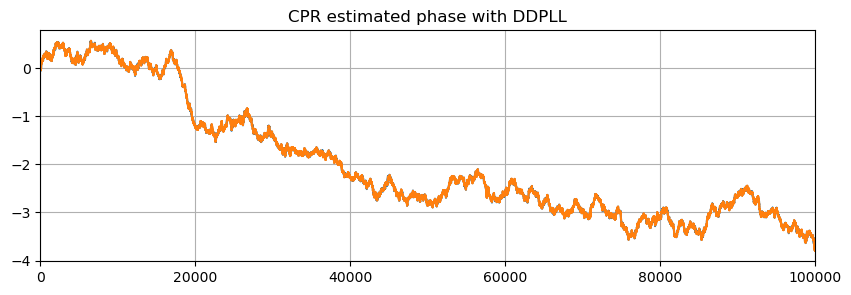

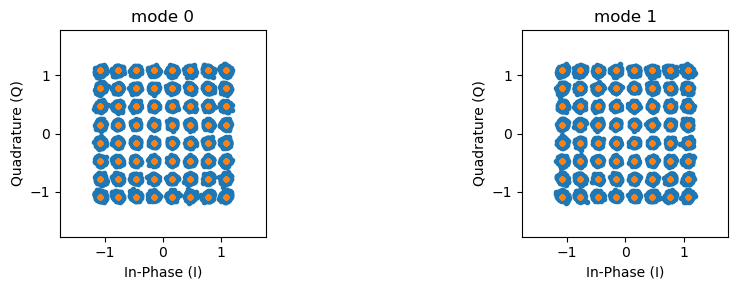

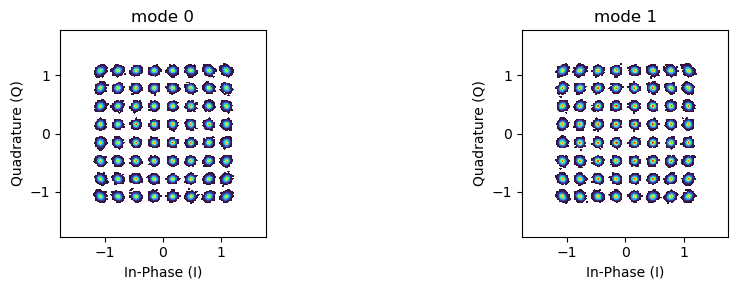

      pol.X      pol.Y      
 SER: 0.00e+00,  0.00e+00
 BER: 0.00e+00,  0.00e+00
 SNR: 27.97 dB,  27.97 dB
 EVM: 0.16 %,    0.16 %
  MI: 6.00 bits, 6.00 bits
 GMI: 6.00 bits, 6.00 bits
NGMI: 1.00,      1.00


In [14]:
paramCPR = parameters()
paramCPR.alg = 'ddpll'
paramCPR.M   = paramTx.M
paramCPR.constType = paramTx.constType
paramCPR.shapingFactor = paramTx.shapingFactor
paramCPR.tau1 = 1/(2*np.pi*10e3)
paramCPR.tau2 = 1/(2*np.pi*10e3)
paramCPR.Kv  = 0.1
paramCPR.returnPhases = True

y_CPR, θ = cpr(sigRx, paramCPR)

plt.figure()
plt.title('CPR estimated phase with DDPLL')
plt.plot(θ,'-')
plt.xlim(0, len(θ))
plt.grid();

discard = 1000

# plot constellations
pconst([y_CPR[discard:-discard,:],d[discard:-discard,:]], pType='fast')
pconst(y_CPR[discard:-discard,:], cmap=constCMAP)

# Performance metrics
ind = np.arange(discard, d.shape[0]-discard)
BER, SER, SNR = fastBERcalc(y_CPR[ind,:], d[ind,:], paramTx.M, paramTx.constType, px=paramTx.pmf)
GMI, NGMI = monteCarloGMI(y_CPR[ind,:], d[ind,:], paramTx.M, paramTx.constType, px=paramTx.pmf)
MI       = monteCarloMI(y_CPR[ind,:], d[ind,:], paramTx.M, paramTx.constType, px=paramTx.pmf)
EVM      = calcEVM(y_CPR[ind,:], paramTx.M, 'qam', d[ind,:])

print('      pol.X      pol.Y      ')
print(' SER: %.2e,  %.2e'%(SER[0], SER[1]))
print(' BER: %.2e,  %.2e'%(BER[0], BER[1]))
print(' SNR: %.2f dB,  %.2f dB'%(SNR[0], SNR[1]))
print(' EVM: %.2f %%,    %.2f %%'%(EVM[0]*100, EVM[1]*100))
print('  MI: %.2f bits, %.2f bits'%(MI[0], MI[1]))
print(' GMI: %.2f bits, %.2f bits'%(GMI[0], GMI[1]))
print('NGMI: %.2f,      %.2f'%(NGMI[0], NGMI[1]))

### Carrier phase recovery with Viterbi&Viterbi

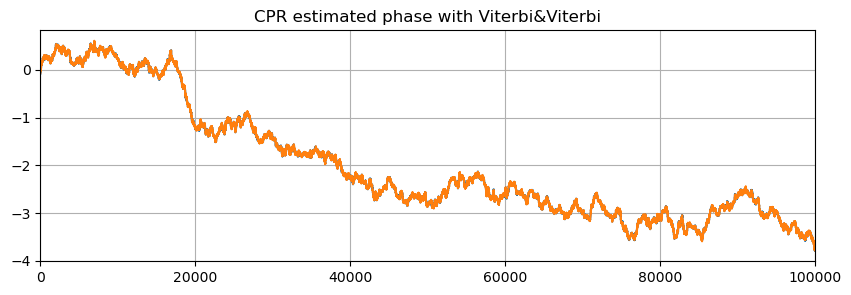

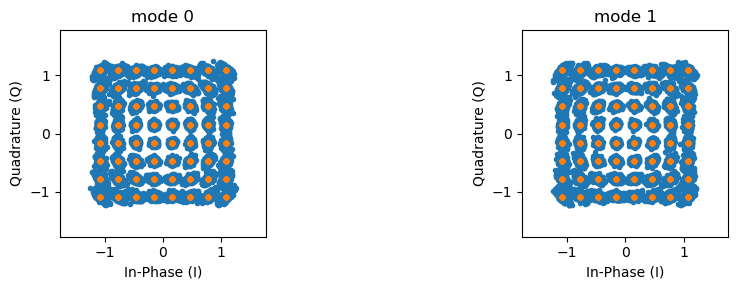

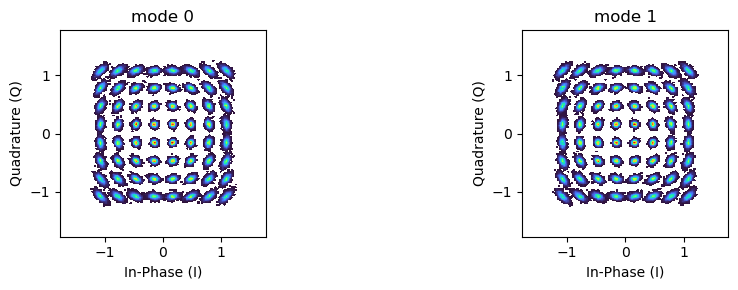

      pol.X      pol.Y      
 SER: 1.75e-03,  1.87e-03
 BER: 3.03e-04,  3.17e-04
 SNR: 25.20 dB,  25.18 dB
 EVM: 0.30 %,    0.30 %
  MI: 5.99 bits, 5.99 bits
 GMI: 5.99 bits, 5.99 bits
NGMI: 1.00,      1.00


In [15]:
paramCPR = parameters()
paramCPR.shapingFactor = paramTx.shapingFactor
paramCPR.alg = 'viterbi'
paramCPR.N = 151
paramCPR.returnPhases = True

y_CPR, θ = cpr(sigRx, paramCPR)

plt.figure()
plt.title('CPR estimated phase with Viterbi&Viterbi')
plt.plot(θ,'-')
plt.xlim(0, len(θ))
plt.grid();

discard = 20000

# plot constellations
pconst([y_CPR[discard:-discard,:],d[discard:-discard,:]], pType='fast')
pconst(y_CPR[discard:-discard,:], cmap=constCMAP)

# Performance metrics
ind = np.arange(discard, d.shape[0]-discard)
BER, SER, SNR = fastBERcalc(y_CPR[ind,:], d[ind,:], paramTx.M, paramTx.constType, px=paramTx.pmf)
GMI, NGMI = monteCarloGMI(y_CPR[ind,:], d[ind,:], paramTx.M, paramTx.constType, px=paramTx.pmf)
MI       = monteCarloMI(y_CPR[ind,:], d[ind,:], paramTx.M, paramTx.constType, px=paramTx.pmf)
EVM      = calcEVM(y_CPR[ind,:], paramTx.M, 'qam', d[ind,:])

print('      pol.X      pol.Y      ')
print(' SER: %.2e,  %.2e'%(SER[0], SER[1]))
print(' BER: %.2e,  %.2e'%(BER[0], BER[1]))
print(' SNR: %.2f dB,  %.2f dB'%(SNR[0], SNR[1]))
print(' EVM: %.2f %%,    %.2f %%'%(EVM[0]*100, EVM[1]*100))
print('  MI: %.2f bits, %.2f bits'%(MI[0], MI[1]))
print(' GMI: %.2f bits, %.2f bits'%(GMI[0], GMI[1]))
print('NGMI: %.2f,      %.2f'%(NGMI[0], NGMI[1]))